In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
SAVE_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase/results'

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
sys.path.append(f'{ROOT_DIR}/code/wasserstein')
import WassersteinOTCost as wot
import importlib
importlib.reload(wot)
from torch.utils.data import Dataset
import pickle
from scipy.stats import bootstrap
from sklearn.preprocessing import StandardScaler

## Load data

In [3]:
def load_data(dataset, cost):
    if dataset == 'Synthetic':
        cost = "{:.2f}".format(cost)
        d1 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_1_{cost}.csv',sep = ' ', names = [i for i in range(13)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_2_{cost}.csv', sep = ' ', names = [i for i in range(13)])
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values
    
    elif dataset == 'Credit':
        cost = "{:.2f}".format(cost)
        d1 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_1_{cost}.csv',sep = ' ', names = [i for i in range(29)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/{dataset}/data_2_{cost}.csv', sep = ' ', names = [i for i in range(29)])
        d1 = d1.sample(n=500)
        d2 = d2.sample(n=500)
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values
    
    elif dataset == 'Weather':
        X1,  y1,  X2, y2 = load_data_weather(cost)

    elif dataset == 'EMNIST':
        cost = "{:.2f}".format(cost)
        d1 = np.load(f'{ROOT_DIR}/data/{dataset}/data_1_{cost}.npz')
        d2 = np.load(f'{ROOT_DIR}/data/{dataset}/data_2_{cost}.npz')

        X1, y1 = d1['data'], d1['labels']
        idx = np.random.choice(np.arange(X1.shape[0]), 500, replace=False)
        X1, y1 = X1[idx], y1[idx]
        X1 = X1.reshape(28*28,-1)

        X2, y2 = d2['data'], d2['labels']
        idx = np.random.choice(np.arange(X2.shape[0]), 500, replace=False)
        X2, y2 = X2[idx], y2[idx]
        X2 = X2.reshape(28*28,-1)

    elif dataset == 'CIFAR':
        cost = "{:.2f}".format(cost)
        X1, X2, y1, y2 = load_cifar_embeddings(cost)

    elif dataset == 'IXITiny':
        X1 = load_data_ixitiny(cost[0])
        X2 = load_data_ixitiny(cost[1])
        return {"1":X1, "2":X2}
    
    elif dataset == 'ISIC':
        X1, y1 = load_data_isic(cost[0])
        X2, y2 = load_data_isic(cost[1])
        
    return {"1":X1, "2":X2}, {"1":y1, "2":y2}

def load_data_weather(costs):
     weather_df = load_all_weather()
     return dictionaryCreator(weather_df, costs, n = 5000)

def load_all_weather():
    DATA_DIR = f'{ROOT_DIR}/data/Weather'
    ##load dataset
    df = pd.read_csv(f'{DATA_DIR}/shifts_canonical_train.csv', nrows = 20000)
    df[((df['climate'] == 'tropical') & (df['fact_temperature'] > 25)) | 
        ((df['climate'] == 'mild temperate') & ((df['fact_temperature'] > 10) & (df['fact_temperature'] < 25))) |
        (df['climate'] == 'dry') & ((df['fact_temperature'] > 5) & (df['fact_temperature'] < 25))]
    df_snow = pd.read_csv(f'{DATA_DIR}/shifts_canonical_eval_out.csv', nrows = 20000)
    df_snow = df_snow[df_snow['fact_temperature'] < 10]
    df = pd.concat([df, df_snow])
    df.dropna(inplace = True)
    return df

def extractData(df, climate, n=5000):
    df = df[df['climate'].isin(climate)]
    ind = np.random.choice(df.shape[0], n)
    X = df.iloc[ind, 6:]
    y = df.iloc[ind, 5]
    return X.values, y.values

def dictionaryCreator(df, climates, n = 5000):
    ##wrangle to dictionary for OT cost calculation
    X1, y1 = extractData(df, climates[0],n = n)
    scaler = StandardScaler()
    X1_normalized = scaler.fit_transform(X1)   
    X2, y2 = extractData(df, climates[1],n = n)
    X2_normalized = scaler.transform(X2)  
   
    return X1_normalized,  y1,  X2_normalized, y2


class EmbeddedImagesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, embedding, label, coarse_label = self.data[idx]
        return image, embedding, label, coarse_label
    
def extract_by_labels(dataset, target_labels, label_type = 'fine'):
    extracted_data = []
    for image, embedding, fine_label, coarse_label in dataset:
        if label_type == 'fine':
            label = fine_label
        else:
            label = coarse_label
        if label in target_labels:
            extracted_data.append((image, embedding, fine_label, coarse_label))
    return EmbeddedImagesDataset(extracted_data)

def get_datasets(dataset, labels_extract, label_type = 'fine'):
    d1 = extract_by_labels(dataset, labels_extract[0], label_type)
    d2 = extract_by_labels(dataset, labels_extract[1], label_type)
    return d1, d2

def sampler(dataset, num_samples):
    indices = random.sample(range(len(dataset)), num_samples)
    sampled_data = [dataset[i] for i in indices]
    embs = np.array([entry[1] for entry in sampled_data])
    label = np.array([entry[2] for entry in sampled_data])
    return embs, label

def load_cifar_embeddings(cost):
    labels = {'0.08': [[x for x in range(10)], [x for x in range(10)]],
            '0.21': [[11,98,29,73, 78, 49, 97, 51, 55, 92], [11,98,29,73, 78, 49, 42, 83, 72, 82]],
            '0.30':[[11,50,78,1,92, 78, 49, 97, 55, 16, 14], [11, 36, 29, 73, 82, 78, 49, 42, 12, 23, 51]],
            '0.38':[[11,50,78,8,92,2,49,98,89,3], [17, 36, 30, 73, 83,28, 34, 42, 10, 20]]}
            
    labels_extract = labels[cost]
    with open(f'{ROOT_DIR}/data/CIFAR/cifar_{1000}_emb.pkl', 'rb') as f:
        data= pickle.load(f)
    d1, d2 = get_datasets(data, labels_extract)
    num_samples = 500
    X1, y1 =  sampler(d1, num_samples)
    X2, y2 =  sampler(d2, num_samples)
    return X1, X2, y1, y2

def load_data_ixitiny(site):
    files = os.listdir(f'{ROOT_DIR}/data/IXITiny/embedding')
    files_site = [file for file in files if site in file]
    embeddings = []
    for file in files_site:
        emb = np.load(f'{ROOT_DIR}/data/IXITiny/embedding/{file}')
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    return embeddings

def load_data_isic(site):
    files = pd.read_csv(f'{ROOT_DIR}/data/ISIC/site_{site}_files_used.csv')
    files = files.sample(500)
    label_counts = files['label'].value_counts()
    selected_labels = label_counts[label_counts > 30].index
    filtered_files = files[files['label'].isin(selected_labels)]
    files_used  = list(filtered_files['image'].values)
    labels_used = list(filtered_files['label'].values)
    embeddings = []
    for file in files_used:
        emb = np.load(f'{ROOT_DIR}/data/ISIC/embedding/center_{site}_{file}.npy')
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    return embeddings, np.array(labels_used)

## Load results

In [4]:
def load_results(DATASET, wasserstein_costs):
    with open(f'{ROOT_DIR}/results/{DATASET}/{DATASET}_scores_full.pkl', 'rb') as f :
        results = pickle.load(f)
        new_results = dict(zip(wasserstein_costs, results.values()))
    return new_results
    
def bootstrap_ci(data, alpha=0.95):
    estimates = {}
    for c in data:
        estimates[c]={}
        for arch in data[c]:
            res = data[c][arch]
            median = np.mean(res)
            bs_reps = bootstrap(np.array(res).reshape(1,-1), statistic=np.mean, n_resamples=1000)
            ci = bs_reps.confidence_interval[0:2]
            estimates[c][arch] = (median, ci[0], ci[1])
    return estimates

def bootstrap_samples(data, n_iterations):
    n = len(data)
    indices = np.random.randint(0, n, (n_iterations, n))
    return data[indices]

def get_difference_estimates(results):
    results_diff = {}
    n_iterations = 1000
    for cost in results:
        results_diff[cost] = {}
        for architecture in list(results[cost].keys())[1:]:
            single = np.array(results[cost]['single'])
            other = np.array(results[cost][architecture])
            bs_single_samples = bootstrap_samples(single, n_iterations)
            bs_other_samples = bootstrap_samples(other, n_iterations)
            bs_single_means = np.median(bs_single_samples, axis=1)
            bs_other_means = np.median(bs_other_samples, axis=1)
            bs_diff = bs_other_means - bs_single_means 
            mean_single = np.median(single)
            median_diff = 100 * np.percentile(bs_diff, 50) / mean_single
            lower_ci_diff = 100 * np.percentile(bs_diff, 5) / mean_single
            upper_ci_diff = 100 * np.percentile(bs_diff, 95) / mean_single
            results_diff[cost][architecture] = (np.round(median_diff, 3), np.round(lower_ci_diff, 3), np.round(upper_ci_diff, 3))
    return pd.DataFrame.from_dict(results_diff, orient='index')

def print_med_results(DATASET):
    results = load_results(DATASET)
    for arch in ['single', 'joint', 'federated', 'pfedme', 'ditto']:
        print(arch)
        for c in results:
            print(np.median(results[c][arch]))
        print('----')

def grapher(results, DATASET, metric, costs, save = True):
    results_long = results.reset_index().rename(columns={'index': 'cost'}).melt(id_vars=['cost'], var_name='architecture')
    results_long[['median_diff', 'lower_ci_diff', 'upper_ci_diff']] = pd.DataFrame(results_long['value'].tolist(), index=results_long.index)
    results_long.drop(columns=['value'], inplace=True)
    results_long
    plt.figure()
    for architecture in results_long['architecture'].unique():
        subset = results_long[results_long['architecture'] == architecture]
        sns.lineplot(x='cost', y='median_diff', marker = 'o', data=subset, label=architecture.capitalize())
        if DATASET not in ['IXITiny', 'ISIC']:
            plt.fill_between(x=subset['cost'], y1=subset['lower_ci_diff'], y2=subset['upper_ci_diff'], alpha=0.2)
    plt.axhline(y=0, color='black', linestyle = '--', alpha = 0.5, label = 'Baseline')
    plt.xlabel('Dataset Cost', fontsize = 14)
    plt.ylabel(f'% Change in {metric}', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    if save == True:
        plt.savefig(f'{SAVE_DIR}/wasserstein/wasserstein_{DATASET}_scores_change.pdf', bbox_inches='tight')
    plt.show()

def process_results(DATASET, wasserstein_costs):
    dataset_dict = {'Synthetic':['F1', '0.03-0.5'],
                'Credit': ['F1', '0.12-0.40'],
                'Weather': ['R2', '0.11-0.48'],
                'EMNIST': ['Accuracy', '0.11-0.39'],
                'CIFAR': ['Accuracy', '0.08-0.38'],
                'ISIC': ['Balanced Accuracy', '0.06-0.30'],
                'IXITiny': ['DICE', '0.08-0.30']}

    results = load_results(DATASET, wasserstein_costs)
    results_estimates = bootstrap_ci(results, alpha=0.95)
    results_diff_estimates = get_difference_estimates(results)
    metric, costs = dataset_dict[DATASET]
    save = True
    grapher(results_diff_estimates, DATASET, metric, costs, save)
    return 

## Synthetic dataset

In [70]:
save = True

In [ ]:
importlib.reload(wot)
dataset = 'Synthetic'
costs = [0.03, 0.1, 0.2, 0.3, 0.4, 0.5]
results_synthetic = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    synthetic_wot = wot.OTCost(dataset, data, label)
    results_synthetic.append(synthetic_wot.calculate_ot_cost())


cost: 254.85
cost: 1710.60
cost: 6727.77
cost: 10712.66
cost: 15223.28
cost: 18862.85


In [ ]:
df = pd.DataFrame([costs, results_synthetic]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

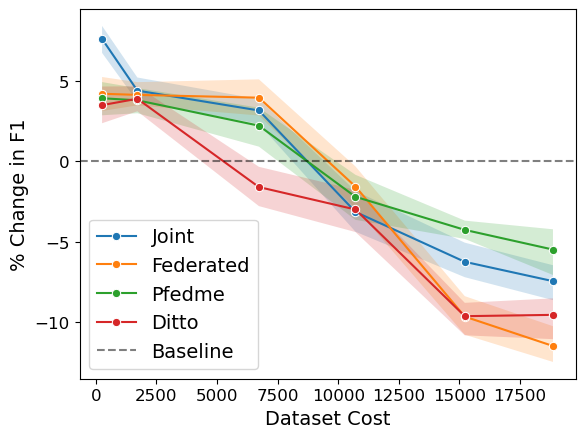

In [179]:
DATASET = 'Synthetic'
process_results(DATASET, results_synthetic)

## Credit dataset

In [30]:
importlib.reload(wot)
costs = [0.12, 0.23, 0.3, 0.4]
dataset = 'Credit'
results_credit = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    credit_wot = wot.OTCost(dataset, data, label)
    results_credit.append(credit_wot.calculate_ot_cost())


cost: 64554.76
cost: 204407.63
cost: 249314.61
cost: 306416.79


In [31]:
df = pd.DataFrame([costs, results_credit]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

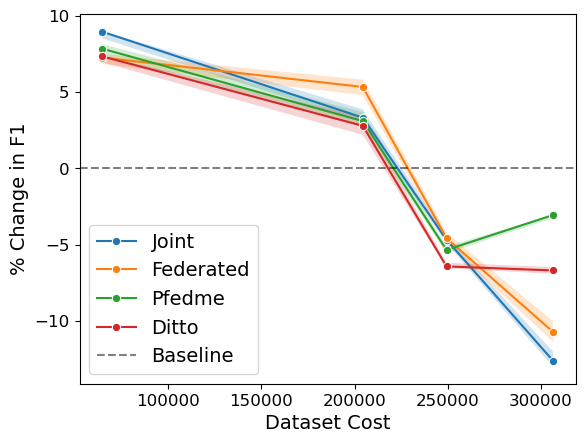

In [180]:
DATASET = 'Credit'
process_results(DATASET, results_credit)

## Weather dataset

In [164]:
importlib.reload(wot)
costs = [0.11, 0.19, 0.3, 0.4, 0.48]
climates = [[['tropical', 'mild temperate'],['tropical', 'mild temperate']],
            [['tropical', 'mild temperate'], ['dry', 'mild temperate']],
            [['tropical', 'mild temperate'], ['dry']],
            [['tropical', 'mild temperate'], ['snow', 'dry']],
            [['tropical', 'mild temperate'], ['snow']]]
dataset = 'Weather'
results_weather = []
for climate in climates:
    data, label = load_data(dataset, climate)
    ## calculate cost
    weather_wot = wot.OTCost(dataset, data, label)
    results_weather.append(weather_wot.calculate_ot_cost())

cost: 65204926412523.12
cost: 575687074370304.75
cost: 47291580391077.89
cost: 77465558786807.23
cost: 59328551172744.61


In [168]:
results_weather_s = sorted(results_weather)
df = pd.DataFrame([costs, results_weather_s]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

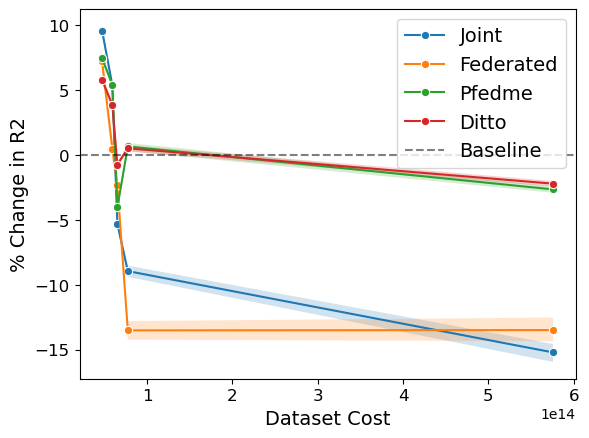

In [181]:
DATASET = 'Weather'
process_results(DATASET, results_weather_s)

## EMNIST

In [36]:
importlib.reload(wot)
costs = [0.11, 0.19, 0.25, 0.34, 0.39]
dataset = 'EMNIST'
results_emnist = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    emnist_wot = wot.OTCost(dataset, data, label)
    results_emnist.append(emnist_wot.calculate_ot_cost())

cost: 777.13
cost: 1085.04
cost: 1421.86
cost: 11898.78
cost: 123975.39


In [186]:
df = pd.DataFrame([costs, results_emnist]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

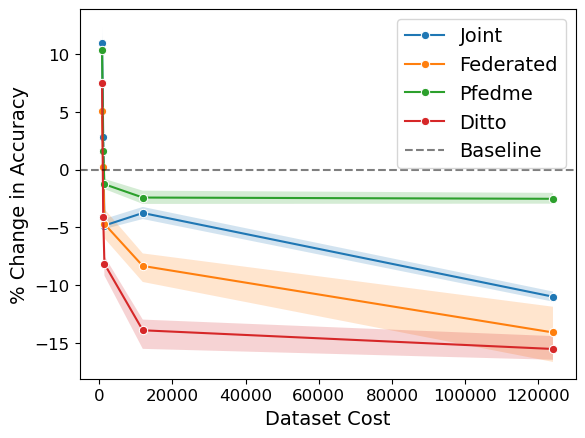

In [185]:
DATASET = 'EMNIST'
process_results(DATASET, results_emnist)

## CIFAR

In [170]:
importlib.reload(wot)
costs = [0.08, 0.21, 0.3, 0.38]
dataset = 'CIFAR'
results_cifar = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    cifar_wot = wot.OTCost(dataset, data, label)
    results_cifar.append(cifar_wot.calculate_ot_cost())

cost: 306883.08
cost: 563074.29
cost: 387134.22
cost: 6342121.35


In [171]:
results_cifar= sorted(results_cifar) #issue with ordering
df = pd.DataFrame([costs, results_cifar]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

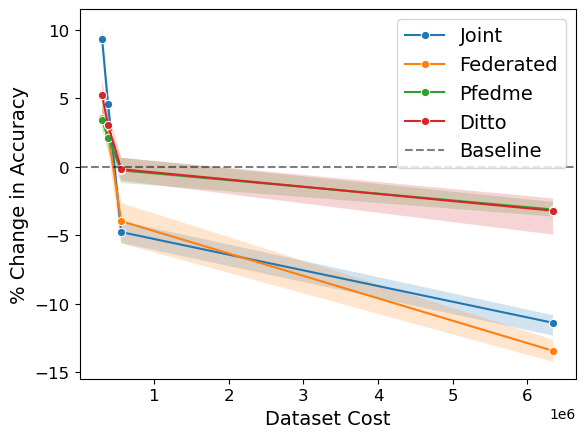

In [182]:
DATASET = 'CIFAR'
process_results(DATASET, results_cifar)

## IXITiny

In [100]:
importlib.reload(wot)
costs = [0.08, 0.28, 0.30]
sites =  [['Guys', 'HH'],
            ['Guys', 'IOP'],
            ['HH', 'IOP']]
dataset = 'IXITiny'
results_ixitiny = []
for site in sites:
    data = load_data(dataset, site)
    label = {'1': np.ones(data['1'].shape[0]), '2': np.ones(data['2'].shape[0])}
    ## calculate cost
    ixitiny_wot = wot.OTCost(dataset, data, label)
    results_ixitiny.append(ixitiny_wot.calculate_ot_cost())


cost: 395045.76
cost: 104348535.30
cost: 675603431.81


In [ ]:
df = pd.DataFrame([costs, results_ixitiny]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

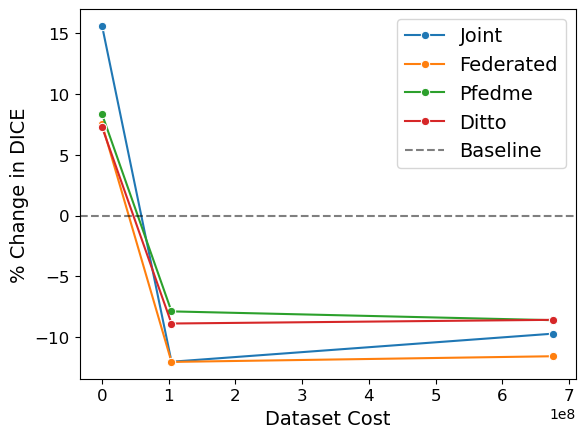

In [183]:
DATASET = 'IXITiny'
process_results(DATASET, results_ixitiny)

## ISIC

In [6]:
importlib.reload(wot)
costs = [0.06, 0.15, 0.19, 0.25, 0.3]
sites = [(2,2), (2,0), (2,3), (2,1), (1,3)]
dataset = 'ISIC'
results_isic = []
for cost, site in zip(costs, sites):
    data, label = load_data(dataset, site)
    ## calculate cost
    isic_wot = wot.OTCost(dataset, data, label)
    results_isic.append(isic_wot.calculate_ot_cost())

cost: 124960151.18
cost: 203910156.53
cost: 176048909.34
cost: 139203869.63
cost: 220356370.03


In [7]:
results_isic_s = sorted(results_isic)
df = pd.DataFrame([costs, results_isic_s]).T
df.columns = ['Ours', 'Wasserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

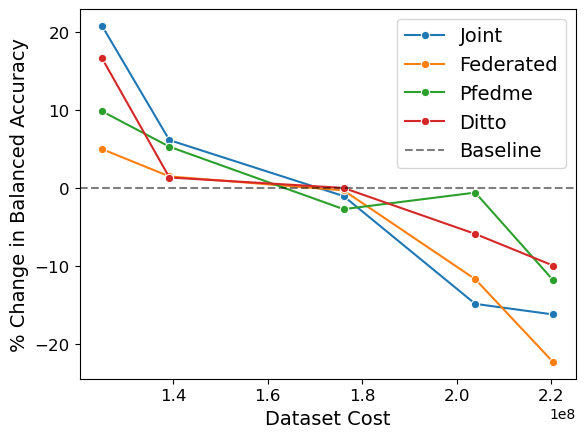

In [8]:
DATASET = 'ISIC'
process_results(DATASET, results_isic_s)